<div style="
    background-color: rgba(46, 139, 87, 0.7); /* seagreen with 70% opacity */
    color: white;
    padding: 20px;
    text-align: center;
    border-radius: 15px; /* rounded corners */
">
    <h1>Spam SMS Classification Using NLP</h1>
</div>


This corpus has been collected from free or free for research sources at the Internet:
The SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [112]:
data = pd.read_csv("Spam_SMS.csv")
data.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


No null values.

In [114]:
(data['Class'].value_counts()/sum(data["Class"].value_counts())).round(2)

Class
ham     0.87
spam    0.13
Name: count, dtype: float64

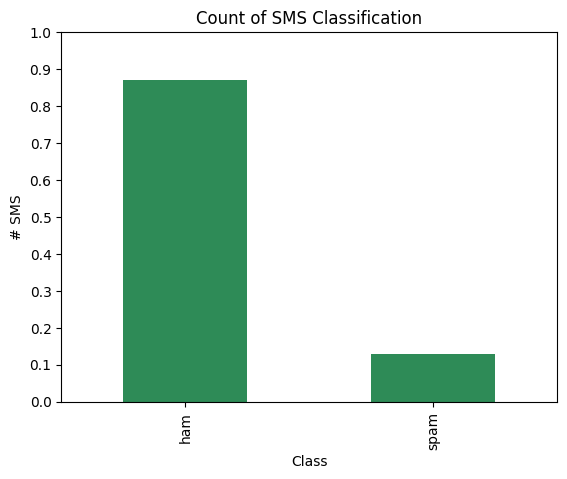

In [115]:
(data['Class'].value_counts()/sum(data["Class"].value_counts())).round(2).plot(kind='bar', color='seagreen')
plt.title("Count of SMS Classification")
plt.ylabel("# SMS")
plt.xlabel("Class")
plt.ylim(0.0,1.0)
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.show()

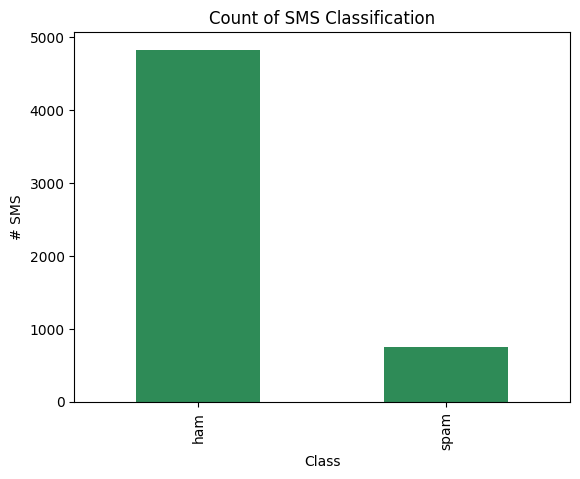

In [116]:
data['Class'].value_counts().plot(kind='bar', color='seagreen')
plt.title("Count of SMS Classification")
plt.ylabel("# SMS")
plt.xlabel("Class")
plt.show()

As it is shown on the graph, dataset is not balanaced. There is 87% of the data as ham SMS, while the rest 13% is spam.

### POS Tagging

In [117]:
nlp = spacy.load("en_core_web_sm")

In [118]:
ham_sms = data[data["Class"] == 'ham']
spam_sms = data[data["Class"] == 'spam']

In [119]:
ham_spacydoc = list(nlp.pipe(ham_sms["Message"]))
spam_spacydoc = list(nlp.pipe(spam_sms["Message"]))

In [120]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [121]:
# tag spam dataset 
spam_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(spam_spacydoc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    spam_tagsdf.append(tags)
        
spam_tagsdf = pd.concat(spam_tagsdf)   

# tag ham dataset 
ham_tagsdf = []

for ix, doc in enumerate(ham_spacydoc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    ham_tagsdf.append(tags)
        
ham_tagsdf = pd.concat(ham_tagsdf)  

In [122]:
# token frequency count (spam)
pos_counts_spam = spam_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_spam.head()

,token,pos_tag,counts
50,.,PUNCT,988
0,!,PUNCT,510
38,",",PUNCT,376
3824,to,ADP,363
2445,a,DET,360


In [123]:
# token frequency count (ham)
pos_counts_ham = ham_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_ham.head()

,token,pos_tag,counts
77,.,PUNCT,3926
1583,I,PRON,1956
10836,you,PRON,1695
53,",",PUNCT,1547
389,?,PUNCT,1319


In [124]:
# frequencies of pos tags
pos_counts_spam.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
PROPN    1221
NOUN     1001
NUM       652
VERB      481
ADJ       279
ADV       101
PRON       74
ADP        63
AUX        55
X          45
Name: token, dtype: int64

The Part-of-Speech (POS) analysis of spam messages reveals that these texts are predominantly composed of proper nouns (PROPN), common nouns (NOUN), and numbers (NUM).
The frequent occurrence of proper nouns indicates that spam messages often reference brand names, product names, or company names, aiming to promote specific entities or services. The high presence of numbers further supports this, as spam commonly includes prices, phone numbers, dates, discounts, and promotional codes.
In contrast, the relatively low frequency of verbs (VERB), pronouns (PRON), and auxiliary verbs (AUX) demonstrates that spam messages rarely involve personal communication or interaction.

In [125]:
# frequencies of pos tags
pos_counts_ham.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     3581
PROPN    2479
VERB     2075
ADJ      1012
ADV       505
NUM       223
PRON      181
INTJ      178
ADP       161
AUX       148
Name: token, dtype: int64

The linguistic composition of ham (non-spam) messages is different from that of spam. Ham messages contain more verbs (VERB), adjectives (ADJ), adverbs (ADV), and pronouns (PRON), which indicates that these messages are more conversational and personal.
<br>
The dominance of common nouns (NOUN) and proper nouns (PROPN) shows that ham messages still refer to people, places, and things, but the much greater presence of verbs and pronouns suggests that these messages typically describe actions, emotions, and personal interactions rather than advertisements or announcements.
<br>
Furthermore, the appearance of interjections (INTJ) (e.g., “hey”, “wow”, “ok”) reinforces the idea that ham messages often involve informal, human communication.

In [126]:
# dive into diferences in nouns
pos_counts_ham[pos_counts_ham.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
4992,day,NOUN,177
9958,time,NOUN,172
3074,U,NOUN,153
10180,u,NOUN,149
10007,today,NOUN,109
7156,lor,NOUN,106
10506,way,NOUN,97
7749,night,NOUN,96
6367,home,NOUN,87
10031,tomorrow,NOUN,77


In [127]:
# dive into diferences in nouns
pos_counts_spam[pos_counts_spam.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
3496,prize,NOUN,73
3966,week,NOUN,59
2647,cash,NOUN,57
3788,text,NOUN,56
3646,service,NOUN,50
2254,U,NOUN,49
2004,STOP,NOUN,45
2616,call,NOUN,45
3274,mobile,NOUN,42
3584,reply,NOUN,40


The lexical analysis of noun usage reveals a clear distinction between spam and ham messages.
Ham messages center around personal life, emotions, and social interaction, reflected in nouns like day, love, home, and time.
In contrast, spam messages revolve around commercial and promotional concepts — prize, cash, service, reply, customer — emphasizing persuasion, incentives, and instructions.

This confirms that spam messages are informational and transactional, designed to trigger user action, whereas ham messages are relational and expressive, focused on human connection and everyday communication.

<div style="
    border-left: 5px solid seagreen;
    padding: 10px;
    text-align: left;
">
    <h3>Pre-processing</h3>
</div>

During preprocessing, the message text is converted to lowercase, punctuation marks are removed, and stop words are eliminated.

In [128]:
data['message_clean'] = data['Message'].str.lower()

In [129]:
data['message_clean'] = data['message_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [130]:
en_stopwords = stopwords.words('english')
data['message_clean'] = data['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [131]:
data

,Class,Message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though
...,...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried 2 contact u u 750 pound prize 2...
5570,ham,Will ü b going to esplanade fr home?,ü b going esplanade fr home
5571,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5572,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like id interested buying s...


In [132]:
# tokenize 
data['message_clean'] = data.apply(lambda x: word_tokenize(x['message_clean']), axis=1)

Then, the text is tokenized, which means it is split into individual words or tokens that can be analyzed separately.

<b>Lemmatization

In [133]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["message_clean"] = data["message_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In this step, lemmatization is applied to the tokenized text using the WordNetLemmatizer. Lemmatization reduces each word to its base or dictionary form (lemma), ensuring that different variations of a word are treated as the same term. For example, words like ‘running’, ‘runs’, and ‘ran’ are all reduced to ‘run’. This helps improve the consistency and quality of the text data for further analysis.


<b>N-gram Frequency Analysis

In the next step, unigrams, bigrams, and trigrams are extracted from both spam and ham messages to analyze the most frequent word combinations. This helps identify common linguistic patterns or keywords that distinguish spam messages from legitimate (ham) ones.

In [134]:
tokens_clean_ham = sum(data[data['Class'] == 'ham']['message_clean'], [])
tokens_clean_spam = sum(data[data['Class'] == 'spam']['message_clean'], [])

In [135]:
# most common unigrams after preprocessing - ham
unigrams_ham = (pd.Series(nltk.ngrams(tokens_clean_ham, 1)).value_counts()).reset_index()[:10]
print(unigrams_ham)

     index  count
0     (u,)   1040
1    (im,)    460
2   (get,)    314
3     (2,)    309
4    (go,)    276
5  (dont,)    276
6  (ltgt,)    276
7    (ok,)    273
8    (ur,)    246
9  (come,)    245


In [136]:
# most common unigrams after preprocessing - spam
unigrams_spam = (pd.Series(nltk.ngrams(tokens_clean_spam, 1)).value_counts()).reset_index()[:10]
print(unigrams_spam)

       index  count
0    (call,)    359
1    (free,)    216
2       (2,)    173
3       (u,)    155
4     (txt,)    150
5      (ur,)    144
6    (text,)    137
7  (mobile,)    135
8       (4,)    119
9   (claim,)    115


In [137]:
# most common bigrams after preprocessing - spam
bigrams_ham = (pd.Series(nltk.ngrams(tokens_clean_ham, 2)).value_counts()).reset_index()[:10]
print(bigrams_ham)

             index  count
0        (gon, na)     58
1    (call, later)     52
2      (ill, call)     48
3      (let, know)     41
4     (sorry, ill)     39
5           (r, u)     37
6           (u, r)     33
7     (dont, know)     33
8         (wan, 2)     31
9  (good, morning)     31


In [138]:
# most common bigrams after preprocessing - spam
bigrams_spam = (pd.Series(nltk.ngrams(tokens_clean_spam, 2)).value_counts()).reset_index()[:10]
print(bigrams_spam)

                 index  count
0       (please, call)     44
1  (customer, service)     27
2            (po, box)     27
3         (1000, cash)     25
4         (contact, u)     24
5   (guaranteed, call)     23
6  (prize, guaranteed)     22
7         (send, stop)     20
8        (every, week)     19
9  (await, collection)     19


In [139]:
# most common trigrams after preprocessing - ham
trigrams_ham = (pd.Series(nltk.ngrams(tokens_clean_ham, 3)).value_counts()).reset_index()[:10]
print(trigrams_ham)

                  index  count
0    (ill, call, later)     42
1    (sorry, ill, call)     38
2           (u, wan, 2)     21
3         (im, gon, na)     20
4    (happy, new, year)     19
5  (pls, send, message)     13
6  (pick, phone, right)     12
7   (cant, pick, phone)     12
8    (right, pls, send)     12
9   (phone, right, pls)     12


In [140]:
# most common trigrams after preprocessing - spam
trigrams_spam = (pd.Series(nltk.ngrams(tokens_clean_spam, 3)).value_counts()).reset_index()[:10]
print(trigrams_spam)

                        index  count
0   (prize, guaranteed, call)     21
1   (call, customer, service)     15
2  (reply, call, 08000930705)     14
3         (land, line, claim)     14
4    (private, 2003, account)     13
5  (2003, account, statement)     13
6    (guaranteed, 1000, cash)     12
7    (camcorder, reply, call)     12
8     (show, 800, unredeemed)     12
9          (every, week, txt)     11


To better understand the language patterns in the dataset, unigram, bigram, and trigram frequencies were analyzed separately for spam and ham messages.

Spam messages most commonly include unigrams such as “call”, “free”, “txt”, and “claim”, which are strongly associated with promotional or prize-related content. Common bigrams and trigrams like “please call”, “customer service”, “prize guaranteed”, and “guaranteed 1000 cash” further indicate a focus on advertisements, offers, and calls to action.

Ham messages, on the other hand, are dominated by everyday conversational words such as “u”, “im”, “get”, “ok”, and “come”. Common bigrams and trigrams like “ill call later”, “let know”, and “good morning” reflect informal, personal communication typical of genuine (non-spam) messages.

<div style="
    border-left: 5px solid seagreen;
    padding: 10px;
    text-align: left;
">
    <h3>Sentiment Analysis</h3>
</div>

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a lexicon and rule-based sentiment analysis tool designed to analyze textual data, particularly short, informal messages like tweets or SMS. It assigns sentiment scores to a piece of text across four categories: positive, negative, neutral, and a combined compound score that summarizes the overall sentiment.

In [141]:
vader_sentiment = SentimentIntensityAnalyzer()

In [142]:
data['vader_sentiment_score'] = data['Message'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [143]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [144]:
data.head(3)

,Class,Message,message_clean,vader_sentiment_score,vader_sentiment_label
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...",0.4019,positive
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]",0.4767,positive
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",0.7964,positive


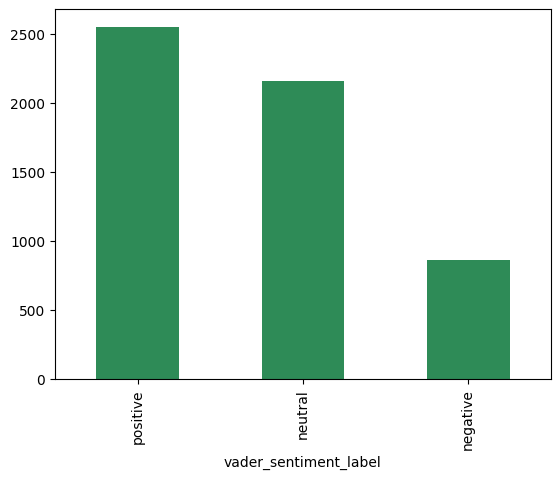

In [145]:
data['vader_sentiment_label'].value_counts().plot.bar(color='seagreen')
plt.show()

The plot indicates that most of the messages are positive or neutral, while fewer messages are negative

C:\Users\user\AppData\Local\Temp\ipykernel_25724\2214441476.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

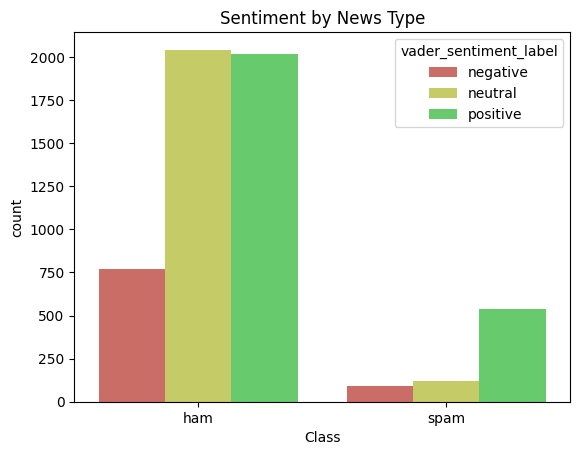

In [146]:
sns.countplot(
    x = 'Class',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
) \
.set(title='Sentiment by News Type')

As shown in the plot, ham messages have a higher proportion of neutral messages compared to spam messages.

<div style="
    border-left: 5px solid seagreen;
    padding: 10px;
    text-align: left;
">
    <h3>Classification Models</h3>
</div> 

In [147]:
X = [','.join(map(str, l)) for l in data['message_clean']]
Y = data['Class']

In [148]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())
bag_of_words

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,...,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,üll
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

<div style="
    border-left: 5px solid seagreen;
    padding: 10px;
    text-align: left;
">
    <h4>Logistic Regression</h4>
</div> 

In [150]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [151]:
y_pred_lr = lr.predict(X_test)

In [152]:
print(round(accuracy_score(y_pred_lr, y_test), 4), "%")

0.9773 %


In [153]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1438
        spam       0.98      0.86      0.91       235

    accuracy                           0.98      1673
   macro avg       0.98      0.93      0.95      1673
weighted avg       0.98      0.98      0.98      1673



As seen from the results, the model achieved a high accuracy of 0.98, indicating that only a small number of messages were misclassified overall. The precision values for both classes (0.98–0.99) are also high, meaning that among all messages predicted as ham or spam, only a small proportion were incorrectly classified. However, the recall value for spam messages is relatively low (0.85), suggesting that a noticeable number of actual spam messages were incorrectly labeled as ham. This indicates that the model could be improved by focusing on better detection of spam messages — for example, by adjusting the decision threshold, using class weighting, or collecting more diverse spam samples to balance the dataset.

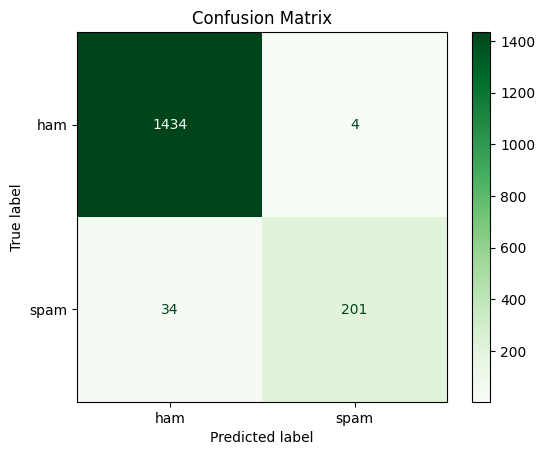

In [154]:
cm = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

<div style="
    border-left: 5px solid seagreen;
    padding: 10px;
    text-align: left;
">
    <h4>Support Vector Machine</h4>
</div> 

In [155]:
svm = SGDClassifier(random_state=0).fit(X_train, y_train)

In [156]:
y_pred_svm = svm.predict(X_test)

In [157]:
print(round(accuracy_score(y_pred_svm, y_test), 4), "%")

0.9833 %


In [158]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1438
        spam       0.97      0.91      0.94       235

    accuracy                           0.98      1673
   macro avg       0.98      0.95      0.96      1673
weighted avg       0.98      0.98      0.98      1673



In comparison to the Linear Regression model, the Support Vector Machine model demonstrates slightly better performance, achieving an accuracy of 0.99. While the precision values remain similar, the SVM model shows an improvement in recall for spam messages, increasing to 0.87, indicating a better ability to correctly identify spam messages.

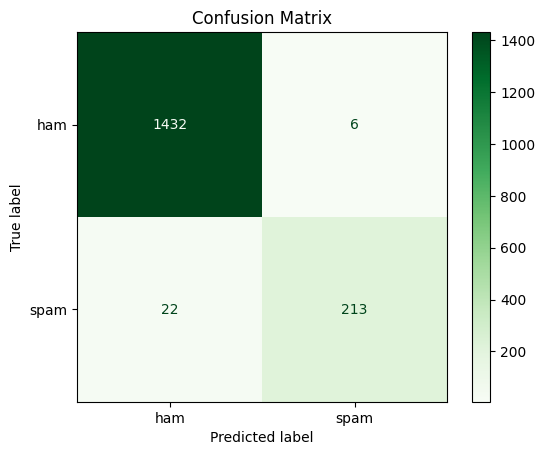

In [159]:
cm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix")
plt.show()

### Test with new data

Additionally, two lists containing three messages each for spam and ham were created to test both models and more clearly illustrate their performance.

In [160]:
ham_mess = ["Hey, are we still meeting at 6 PM for dinner?",
            "Please send me the updated project report by tomorrow morning.", 
            "Happy birthday! Wishing you a great day filled with joy and laughter."]

In [161]:
spam_mess = ["Congratulations! You’ve won a $500 gift card! Click here to claim your prize now: www.freegift.com",
             "URGENT! Your account has been suspended. Verify your details immediately at secure-login.net", 
             "Get rich working from home! Earn $1,000 daily with no experience. Sign up at easycashnow.com"]

In [162]:
countvec_ham = countvec.transform(ham_mess)
ham_mess_test = pd.DataFrame(countvec_ham.toarray(), columns = countvec.get_feature_names_out())

countvec_spam = countvec.transform(spam_mess)
spam_mess_test = pd.DataFrame(countvec_spam.toarray(), columns = countvec.get_feature_names_out())    

In [163]:
pred_svm_ham = svm.predict(ham_mess_test)
pred_svm_spam = svm.predict(spam_mess_test)
print("Ham messages", pred_svm_ham, "\nSpam messages:", pred_svm_spam)

Ham messages ['ham' 'ham' 'ham'] 
Spam messages: ['spam' 'ham' 'ham']


In [164]:
pred_lr_ham = lr.predict(ham_mess_test)
pred_lr_spam = lr.predict(spam_mess_test)
print("Ham messages", pred_lr_ham, "\nSpam messages:", pred_lr_spam)

Ham messages ['ham' 'ham' 'ham'] 
Spam messages: ['spam' 'ham' 'ham']


As shown by the results, it is noticeable that both models have difficulty correctly predicting spam messages. The Support Vector Machine correctly classified two out of three spam messages, whereas the Linear Regression model correctly identified only one.